# **IMPORTADO DE MÓDULOS**

In [64]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import tensorflow as tf
tf.version.VERSION

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from keras.regularizers import l2

In [65]:
V55= np.load('/home/josea/Co60_5cm_5cm.npy')
V28= np.load('/home/josea/Co60_2cm_8cm.npy')
V82= np.load('/home/josea/Co60_8cm_2cm.npy')

In [66]:
source = 'Na22'
path = '/home/josea/PracticaTimingDigital/pulso_' + source + '_filt_norm.npz'

data = np.load(path)
pulsos_practica_master = data['data']

In [67]:
from functions import gauss, gauss_fit, momentos, pulso, get_mean_pulse_from_set, delay_pulse_pair, create_and_delay_pulse_pair, move_to_reference

# **PREPROCESSING AND FUNCTIONS**

In [68]:
#--------------------------------Interpolar pulsos reales---------------------------------
input = V28
EXTRASAMPLING = 8
Nt = np.shape(input)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func_V28 = interp1d(tiempo,V28,  kind='cubic', axis=1)
new_V28 = interp_func_V28(tiempo_new)

interp_func_V55 = interp1d(tiempo,V55,  kind='cubic', axis=1)
new_V55 = interp_func_V55(tiempo_new)

interp_func_V82 = interp1d(tiempo,V82,  kind='cubic', axis=1)
new_V82 = interp_func_V82(tiempo_new)

interp_func_practica = interp1d(tiempo,pulsos_practica_master,  kind='cubic', axis=1)
new_pulsos_practica = interp_func_practica(tiempo_new)

#---------------------------------------------------------------- Align the pulses -----------------------------------
align_steps = 20
new_pulsos_practica[:,:,1] = np.roll(new_pulsos_practica[:,:,1], align_steps)
new_pulsos_practica[:,:align_steps,1] = np.random.normal(scale = 1e-3, size = align_steps)

#----------------------------------------------------- Print important information -----------------------------------
print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 600
Time step: 0.20
New number of time points: 4800
New time step: 0.0250


In [69]:
Num_casos = 1000
Nc = 2

t_shift = 8 #In time steps
t = np.linspace(0,Nt,Nt_new)
t0 = 65 + np.random.randint(10, size=Num_casos)

In [70]:
#------------------------------------- Define size of train set from datos practica ---------------------------------
Ntrain_practica = int(0.4*new_pulsos_practica.shape[0])
Ntest_practica = int(0.1*new_pulsos_practica.shape[0])
print('Número de casos de entrenamiento de la práctica: ', Ntrain_practica)
print('Número de casos de Test de la práctica: ', Ntest_practica)

Número de casos de entrenamiento de la práctica:  8890
Número de casos de Test de la práctica:  2222


# **GENERATE MEAN PULSE PER DETECTOR**

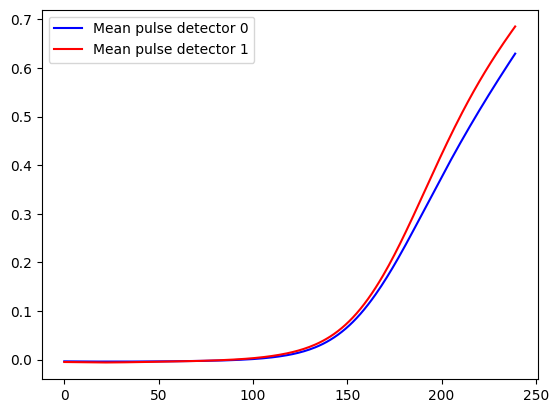

In [71]:
mean_pulse_dec0 = get_mean_pulse_from_set(new_pulsos_practica, channel = 0)
mean_pulse_dec1 = get_mean_pulse_from_set(new_pulsos_practica, channel = 1)

#-------------------------------------- Plot cropped mean pulses -----------------------------
start = 50*EXTRASAMPLING
stop = 80*EXTRASAMPLING

plt.plot(mean_pulse_dec0[start:stop], 'b-', label = 'Mean pulse detector 0')
plt.plot(mean_pulse_dec1[start:stop], 'r-', label = 'Mean pulse detector 1')
plt.legend()

# **DETECTOR 0**

In [72]:
#--------------------------------- Detector 0 definitions -------------------------
tau_rise_dec0 = 15
tau_drop_dec0 = 150

Text(0, 0.5, 'Voltage [A.U]')

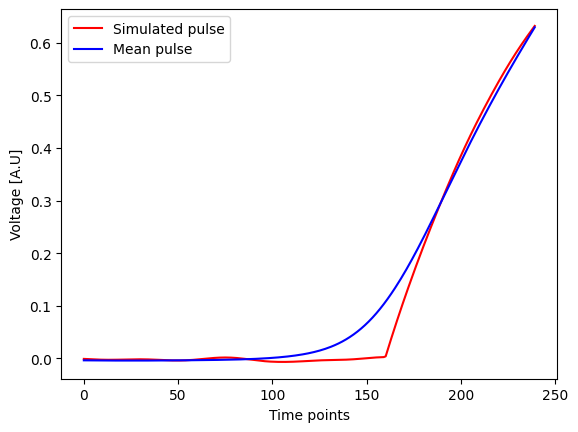

In [73]:
pulso_original_dec0 = pulso(t, 70, tau_rise = tau_rise_dec0)

plt.plot(pulso_original_dec0[start:stop],'r-', label = 'Simulated pulse')
plt.plot(mean_pulse_dec0[start:stop],'b-', label = 'Mean pulse')
plt.legend()
plt.xlabel('Time points')
plt.ylabel('Voltage [A.U]')

In [74]:
#------------------------------ Create simulated pulses ---------------------------------
INPUT_dec0 = np.zeros((Num_casos,Nt_new))
for i in range(Num_casos):
  centro = t0[i]
  PULSO = pulso(t, centro,  tau_rise = tau_rise_dec0)
  INPUT_dec0[i,:] = PULSO

In [75]:
#-------------------------------- Delay simulated pulses --------------------------------------------
delays_dec0, moved_pulses_dec0 = move_to_reference(mean_pulse_dec0, np.expand_dims(INPUT_dec0, axis = -1), start = start, stop = stop, max_delay = 240, channel = 0)
INPUT_dec0, REF_dec0 = create_and_delay_pulse_pair(moved_pulses_dec0, new_time_step, t_shift = 0, delay_steps = 20, NOISE = True)


#--------------------------------- Move rest of the pulses to align with mean and then delay them ---------------------------------------
delays2_dec0, moved_pulses2_dec0 = move_to_reference(mean_pulse_dec0, new_pulsos_practica[:Ntrain_practica,:,:], start = start, stop = stop, max_delay = 240, channel = 0)
INPUT2_dec0, REF2_dec0 = create_and_delay_pulse_pair(moved_pulses2_dec0, new_time_step, t_shift = 0, delay_steps = 20, NOISE = True)


#--------------------------------- Create train set ----------------------------------------------------
trainX_dec0 = np.concatenate((INPUT_dec0[:,:,:], INPUT2_dec0[:,:,:]), axis = 0)
REF_train_dec0 = np.concatenate((REF_dec0[:], REF2_dec0[:]))

In [76]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec0 = momentos(trainX_dec0)

min_dec0 = np.min(M_Train_dec0)
max_dec0 = np.max(M_Train_dec0)

M_Train_dec0 = (M_Train_dec0-min_dec0)/(max_dec0 - min_dec0)

NM = np.shape(M_Train_dec0)[1]
print(M_Train_dec0.shape, "NM =", NM)
print('min_dec0:',min_dec0)
print('max_dec0:',max_dec0)

(9890, 12, 2) NM = 12
min_dec0: 1.0978436880448608
max_dec0: 37.53193628451128


# **DETECTOR 1**

In [77]:
#--------------------------------- Detector 1 definitions -------------------------
tau_rise_dec1 = 17
tau_drop_dec1 = 150

Text(0, 0.5, 'Voltage [A.U]')

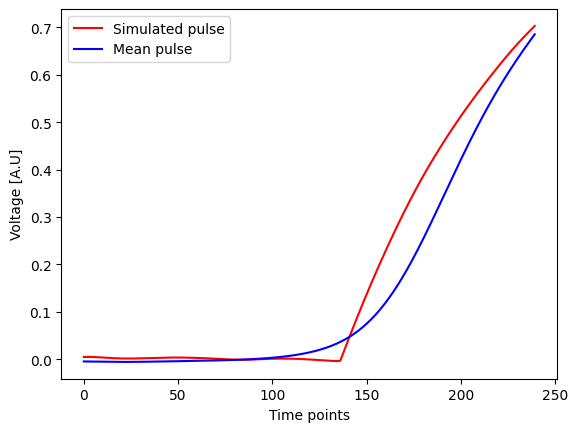

In [78]:
pulso_original_dec1 = pulso(t, 67, tau_rise = tau_rise_dec1)

plt.plot(pulso_original_dec1[start:stop],'r-', label = 'Simulated pulse')
plt.plot(mean_pulse_dec1[start:stop],'b-', label = 'Mean pulse')
plt.legend()
plt.xlabel('Time points')
plt.ylabel('Voltage [A.U]')

In [79]:
#------------------------------ Create simulated pulses ---------------------------------
INPUT_dec1 = np.zeros((Num_casos,Nt_new))

for i in range(Num_casos):
  centro = t0[i]
  PULSO = pulso(t, centro,  tau_rise = tau_rise_dec1)
  INPUT_dec1[i,:] = PULSO

In [80]:
#----------------------------- Move simulated pulses to align with mean and then delay them --------------------------------------------
delays_dec1, moved_pulses_dec1 = move_to_reference(mean_pulse_dec1, np.expand_dims(INPUT_dec1, axis = -1), start = start, stop = stop, max_delay = 240, channel = 0)
INPUT_dec1, REF_dec1 = create_and_delay_pulse_pair(moved_pulses_dec1, new_time_step, t_shift = 0, delay_steps = 20, NOISE = True)


#--------------------------------- Move rest of the pulses to align with mean and then delay them ---------------------------------------
delays2_dec1, moved_pulses2_dec1 = move_to_reference(mean_pulse_dec1, new_pulsos_practica[:Ntrain_practica,:,:], start = start, stop = stop, max_delay = 240, channel = 1)
INPUT2_dec1, REF2_dec1 = create_and_delay_pulse_pair(moved_pulses2_dec1, new_time_step, t_shift = 0, delay_steps = 20, NOISE = True)


#--------------------------------- Create train set ----------------------------------------------------
trainX_dec1 = np.concatenate((INPUT_dec1[:,:,:], INPUT2_dec1[:,:,:]), axis = 0)
REF_train_dec1 = np.concatenate((REF_dec1[:], REF2_dec1[:]))

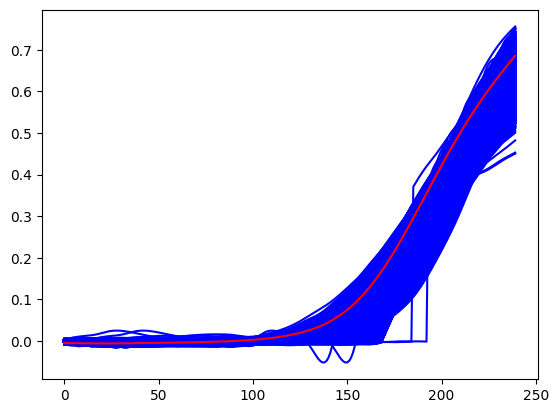

In [81]:
for i in range(trainX_dec1.shape[0]):
    plt.plot(trainX_dec1[i,:],'b-')
plt.plot(mean_pulse_dec1[start:stop],'r-')

In [82]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec1 = momentos(trainX_dec1)

min_dec1 = np.min(M_Train_dec1)
max_dec1 = np.max(M_Train_dec1)

M_Train_dec1 = (M_Train_dec1-min_dec1)/(max_dec1 - min_dec1)

NM = np.shape(M_Train_dec1)[1]
print(M_Train_dec1.shape, "NM =", NM)
print('min_dec1:',min_dec1)
print('max_dec1:',max_dec1)

(9890, 12, 2) NM = 12
min_dec1: 1.216106991634985
max_dec1: 35.79256722605127


# **FULL TOF**

In [83]:
#-------------------------------------- Create Reference pulses set ----------------------------------------
REFERENCE_PULSE_dec0 = np.tile(mean_pulse_dec0[start:stop], (trainX_dec0.shape[0],2,1)).swapaxes(1,2)
REFERENCE_PULSE_dec1 = np.tile(mean_pulse_dec1[start:stop], (trainX_dec1.shape[0],2,1)).swapaxes(1,2)

M_REF_dec0 = momentos(REFERENCE_PULSE_dec0)
M_REF_dec0 = (M_REF_dec0 - min_dec0)/(max_dec0-min_dec0)

M_REF_dec1 = momentos(REFERENCE_PULSE_dec1)
M_REF_dec1 = (M_REF_dec1 - min_dec1)/(max_dec1-min_dec1)

In [84]:
#-------------------------------------------- Create test set -------------------------------------------------------------
delays_test_dec0, moved_pulses_test_dec0 = move_to_reference(mean_pulse_dec0, new_pulsos_practica[Ntrain_practica:Ntrain_practica + Ntest_practica,:,:], start = start, stop = stop, max_delay = 240, channel = 0)
delays_test_dec1, moved_pulses_test_dec1 = move_to_reference(mean_pulse_dec1, new_pulsos_practica[Ntrain_practica:Ntrain_practica + Ntest_practica,:,:], start = start, stop = stop, max_delay = 240, channel = 1)


#------------------------------- Create other positions ------------------------------------------------------------------
t_shift = 8

#new_V55 = new_pulsos_practica[Ntrain_practica:Ntrain_practica+Ntest_practica, start:stop,:]
new_V55 = np.stack((moved_pulses_test_dec0, moved_pulses_test_dec1), axis = 2)
new_V28 = np.zeros_like(new_V55)
new_V82 = np.zeros_like(new_V55)

for i in range(new_V55.shape[0]):
  noise00 = np.random.normal(scale=1e-3, size=t_shift)
  noise0 = np.random.normal(scale=0.01, size = new_V55.shape[1])
  smoothed_noise = gaussian_filter1d(noise0, sigma=10)
  new_V28[i,:,0] = new_V55[i,:,0]
  new_V28[i,:,1] = np.roll(new_V55[i,:,1], t_shift)
  new_V28[i,:,1] = new_V28[i,:,1] + smoothed_noise
  new_V28[i,:t_shift,1] = noise00


for i in range(new_V55.shape[0]):
  noise00 = np.random.normal(scale=1e-3, size=t_shift)
  noise0 = np.random.normal(scale=0.01, size = new_V55.shape[1])
  smoothed_noise = gaussian_filter1d(noise0, sigma=10)
  new_V82[i,:,1] = new_V55[i,:,1]
  new_V82[i,:,0] = np.roll(new_V55[i,:,0], t_shift)
  new_V82[i,:,0] = new_V82[i,:,0] + smoothed_noise
  new_V82[i,:t_shift,0] = noise00


M_V55 = momentos(new_V55)
M_V55_norm = np.zeros_like(M_V55)
M_V55_norm[:,:,0] = (M_V55[:,:,0] - min_dec0)/(max_dec0-min_dec0)
M_V55_norm[:,:,1] = (M_V55[:,:,1] - min_dec1)/(max_dec1-min_dec1)

M_V28 = momentos(new_V28)
M_V28_norm = np.zeros_like(M_V28)
M_V28_norm[:,:,0] = (M_V28[:,:,0] - min_dec0)/(max_dec0-min_dec0)
M_V28_norm[:,:,1] = (M_V28[:,:,1] - min_dec1)/(max_dec1-min_dec1)

M_V82 = momentos(new_V82)
M_V82_norm = np.zeros_like(M_V82)
M_V82_norm[:,:,0] = (M_V82[:,:,0] - min_dec0)/(max_dec0-min_dec0)
M_V82_norm[:,:,1] = (M_V82[:,:,1] - min_dec1)/(max_dec1-min_dec1)


In [110]:
def model_definition(NM):

  inputA = Input(shape=(NM,))
  inputB = Input(shape=(NM,))

  x1 = Dense(128, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1), kernel_regularizer=l2(0.01))
  x2 = Dense(128, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1), kernel_regularizer=l2(0.01))
  x3 = Dense(128, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1), kernel_regularizer=l2(0.01))
  x4 = Dense(1, activation="linear")

  op1A = x1(inputA)
  op2A = x2(op1A)
  op3A = x3(op2A)
  outA = x4(op3A)

  op1B = x1(inputB)
  op2B = x2(op1B)
  op3B = x3(op2B)
  outB = x4(op3B)

  model = Model(inputs=[inputA, inputB], outputs=outA-outB)
  return model

In [116]:
epochs = 50
num_semillas = 5

epsilon = []
bias = []
std = []
training_loss_dec0 = []
training_loss_dec1 = []

TOFN_V28_list = []
TOFN_V55_list = []
TOFN_V82_list = []

directory = '/home/josea/temporal/'


for i in range(num_semillas):

  model_dec0 = model_definition(NM)
  model_dec1 = model_definition(NM)

  opt_dec0 = tf.keras.optimizers.AdamW(learning_rate = 1e-3)
  opt_dec1 = tf.keras.optimizers.AdamW(learning_rate = 1e-3)

  model_dec0.compile(optimizer=opt_dec0,loss='MSE')
  model_dec1.compile(optimizer=opt_dec1,loss='MSE')

  squared_sum = []
  MEC = []
  MSTD = []
  loss_dec0 = []
  loss_dec1 = []
  TOFN_V28_epoch = []
  TOFN_V55_epoch = []
  TOFN_V82_epoch = []

  for epoch in range(epochs):
     history_dec0 = model_dec0.fit(x=[M_Train_dec0[:,:,0], M_Train_dec0[:,:,1]],y = REF_train_dec0, epochs = 5, batch_size = 512, shuffle = True, verbose=1)
     history_dec1 = model_dec1.fit(x=[M_Train_dec1[:,:,0], M_Train_dec1[:,:,1]],y = REF_train_dec1, epochs = 5, batch_size = 512, shuffle = True, verbose=1)
     
     loss_dec0.append(history_dec0.history['loss'][-1])
     loss_dec1.append(history_dec1.history['loss'][-1])

    
     TOFN_dec0_REF_V82 = model_dec0.predict([M_V82_norm[:,:,0],M_REF_dec0[:M_V82_norm.shape[0],:,0]])
     TOFN_dec1_REF_V82 = model_dec1.predict([M_V82_norm[:,:,1],M_REF_dec1[:M_V82_norm.shape[0],:,0]])
     TOFN_dec0_REF_V55 = model_dec0.predict([M_V55_norm[:,:,0],M_REF_dec0[:M_V55_norm.shape[0],:,0]])
     TOFN_dec1_REF_V55 = model_dec1.predict([M_V55_norm[:,:,1],M_REF_dec1[:M_V55_norm.shape[0],:,0]])
     TOFN_dec0_REF_V28 = model_dec0.predict([M_V28_norm[:,:,0],M_REF_dec0[:M_V28_norm.shape[0],:,0]])
     TOFN_dec1_REF_V28 = model_dec1.predict([M_V28_norm[:,:,1],M_REF_dec1[:M_V28_norm.shape[0],:,0]])
    
     TOFN_V28 = (np.squeeze(TOFN_dec0_REF_V28) - new_time_step*delays_test_dec0) - (np.squeeze(TOFN_dec1_REF_V28) - new_time_step*delays_test_dec1)
     TOFN_V55 = (np.squeeze(TOFN_dec0_REF_V55) - new_time_step*delays_test_dec0) - (np.squeeze(TOFN_dec1_REF_V55) - new_time_step*delays_test_dec1)
     TOFN_V82 = (np.squeeze(TOFN_dec0_REF_V82) - new_time_step*delays_test_dec0) - (np.squeeze(TOFN_dec1_REF_V82) - new_time_step*delays_test_dec1)

     #TOFN_V28 = TOFN_dec0_REF_V28 - TOFN_dec1_REF_V28
     #TOFN_V55 = TOFN_dec0_REF_V55 - TOFN_dec1_REF_V55
     #TOFN_V82 = TOFN_dec0_REF_V82 - TOFN_dec1_REF_V82
    
     TOFN_V28_epoch.append(TOFN_V28)
     TOFN_V55_epoch.append(TOFN_V55)
     TOFN_V82_epoch.append(TOFN_V82)


     centroid_V28 = np.mean(TOFN_V28) - np.mean(TOFN_V55)
     centroid_V82 = np.mean(TOFN_V82) - np.mean(TOFN_V55)
     mean_error_centroid = (abs(centroid_V28 + 0.2) + abs(centroid_V82 - 0.2)) / 2
     mean_std = (np.std(TOFN_V82) + np.std(TOFN_V55) + np.std(TOFN_V28)) / 3
     
     squared_sum.append(np.sqrt(mean_error_centroid**2 + mean_std**2))
     MEC.append(mean_error_centroid)
     MSTD.append(mean_std)

     #model_dec0.save(directory + 'model_dec0_' + str(i) + '_' + str(epoch) + '.h5')
     #model_dec1.save(directory + 'model_dec1_' + str(i) + '_' + str(epoch) + '.h5')

  training_loss_dec0.append(loss_dec0)
  training_loss_dec1.append(loss_dec1)
  epsilon.append(squared_sum)
  bias.append(MEC)
  std.append(MSTD)

  TOFN_V28_list.append(TOFN_V28_epoch)
  TOFN_V55_list.append(TOFN_V55_epoch)
  TOFN_V82_list.append(TOFN_V82_epoch)

  tf.keras.backend.clear_session()

epsilon = np.array(epsilon, dtype = 'object')
bias = np.array(bias, dtype='object')
std = np.array(std, dtype='object')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'object')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'object')

TOFN_V28_array = np.array(TOFN_V28_list, dtype = 'object')
TOFN_V55_array = np.array(TOFN_V55_list, dtype = 'object')
TOFN_V82_array = np.array(TOFN_V82_list, dtype = 'object')

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 361.3550
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 333.3820
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 324.8171
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 317.1780
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 309.8194
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 352.9202
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 331.0037
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 322.5428
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - loss: 314.6545
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 307.1256
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 302.6691
Epoch 2/5
20

(array([4]), array([30])) 0.22661405923119532


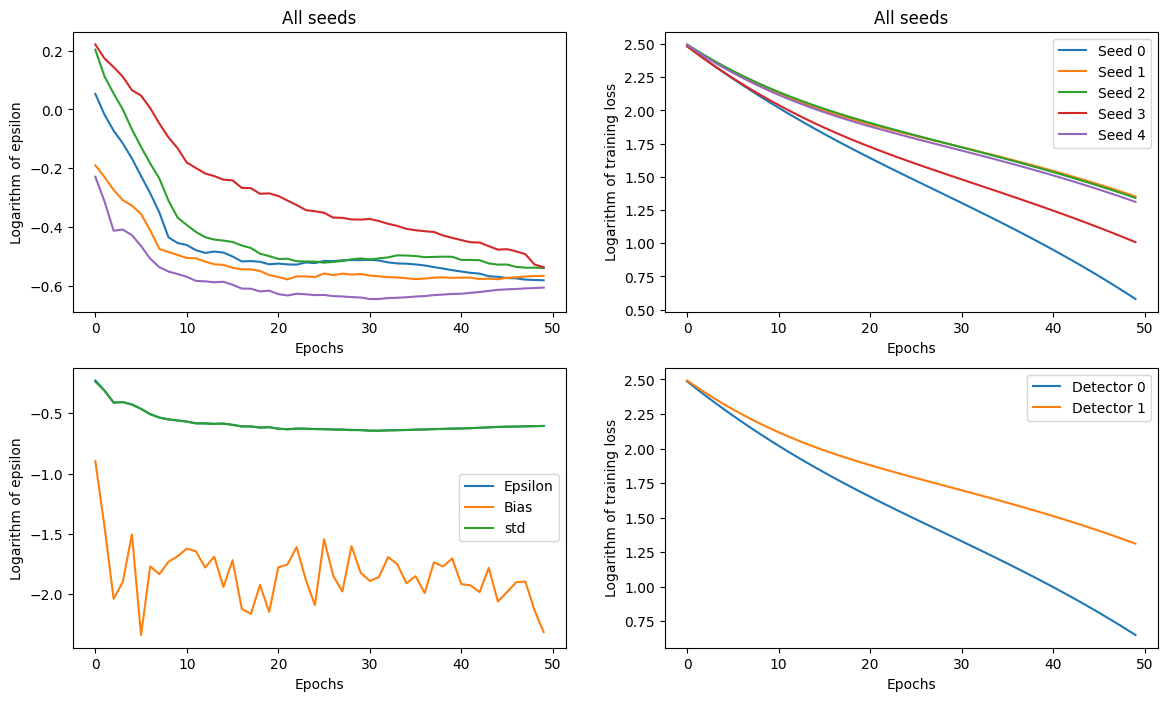

In [119]:
epsilon = np.array(epsilon, dtype='float64')
bias = np.array(bias, dtype='float64')
std = np.array(std, dtype = 'float64')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'float64')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'float64')


print(np.where(epsilon == np.min(epsilon)), np.min(epsilon))
index = 4
plt.figure(figsize=(14,8))

plt.subplot(2,2,1)
for i in range(epsilon.shape[0]):
  plt.plot(np.log10(epsilon[i,:]))
  #plt.plot(np.log10(bias[i,:]))
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')
plt.title('All seeds')

plt.subplot(2,2,2)
for i in range(training_loss_dec0.shape[0]):
  label = 'Seed' + ' ' + str(i)
  #plt.plot(np.log10(training_loss_dec0[i,:]),label=label)
  plt.plot(np.log10(training_loss_dec1[i,:]),label=label)
plt.legend()
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')
plt.title('All seeds')


plt.subplot(2,2,3)
plt.plot(np.log10(epsilon[index,:]), label = 'Epsilon')
plt.plot(np.log10(bias[index,:]), label = 'Bias')
plt.plot(np.log10(std[index,:]), label = 'std')
plt.legend()
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')

plt.subplot(2,2,4)
plt.plot(np.log10(training_loss_dec0[index,:]),label='Detector 0')
plt.plot(np.log10(training_loss_dec1[index,:]),label='Detector 1')
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')

plt.legend()


V82: CENTROID(ns) = 0.209  FWHM(ns) = 0.259  std(ns) = 0.110
V55: CENTROID(ns) = 0.004  FWHM(ns) = 0.248  std(ns) = 0.105
V28: CENTROID(ns) = -0.217  FWHM(ns) = 0.252  std(ns) = 0.107


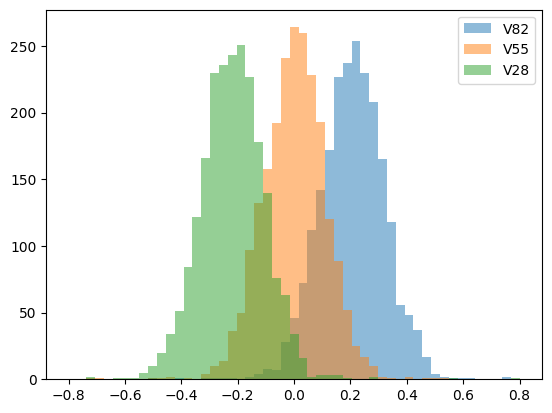

In [120]:
epoch = 30
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_V82, binsN, patchesN  = plt.hist(TOFN_V82_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(TOFN_V55_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(TOFN_V28_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))

In [115]:
Error_V82 = (TOFN_V82_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]) - 0.2)**2
Error_V55 = (TOFN_V55_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]))**2
Error_V28 = (TOFN_V28_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]) + 0.2)**2

Error = np.concatenate((Error_V82, Error_V55, Error_V28))
MSE = np.mean(Error)   
print(MSE)                                                                                                               

0.05068378085676878


# **ENSEMBLE MODEL**

In [90]:
#---------------------------- Get the weighted mean by the accuracy of their bias result ------------------------------------------
weighted_mean_V28 = np.average(np.squeeze(TOFN_V28_array[:,epoch,:]), weights=(1/bias[:,epoch]), axis=0)
weighted_mean_V55 = np.average(np.squeeze(TOFN_V55_array[:,epoch,:]), weights=(1/bias[:,epoch]), axis=0)
weighted_mean_V82 = np.average(np.squeeze(TOFN_V82_array[:,epoch,:]), weights=(1/bias[:,epoch]), axis=0)


V82: CENTROID(ns) = 0.203  FWHM(ns) = 0.419  std(ns) = 0.178
V55: CENTROID(ns) = 0.004  FWHM(ns) = 0.420  std(ns) = 0.178
V28: CENTROID(ns) = -0.201  FWHM(ns) = 0.408  std(ns) = 0.173


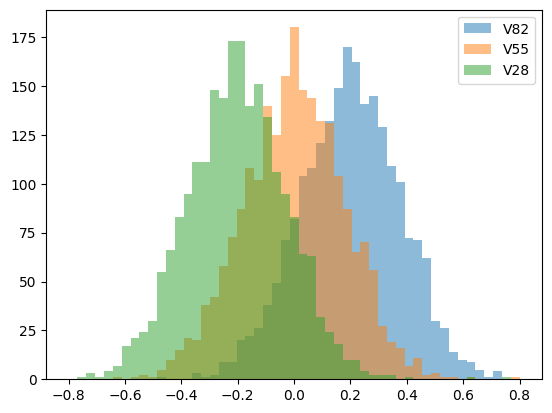

In [91]:
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_V82, binsN, patchesN  = plt.hist(weighted_mean_V82 - np.mean(weighted_mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(weighted_mean_V55 - np.mean(weighted_mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(weighted_mean_V28 - np.mean(weighted_mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))

In [92]:
import time

million_REFERENCE = np.tile(new_V82[0,:,0], (1000000,2,1)).swapaxes(1,2)

million_REFERENCE_moment = momentos(million_REFERENCE)
million_REFERENCE_norm = (million_REFERENCE_moment - min_dec0)/(max_dec0-min_dec0)


million_pulses = np.tile(new_V82[0,:,0], (1000000,2,1)).swapaxes(1,2)
million = momentos(million_pulses)
million_norm = np.zeros_like(million)
million_norm[:,:,0] = (million[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
million_norm[:,:,1] = (million[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(million_norm.shape)

# Measure time in seconds
start_time = time.time()

Test_million = model_dec0.predict([million_REFERENCE_norm[:,:,0],million_norm[:,:,0]])

end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")

(1000000, 12, 2)
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 12s 377us/step
Elapsed time: 17.712417364120483 seconds
